In [1]:
import gradcam
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

import pandaGenerator
gradcam.seed_everything(gradcam.config.seed)



df = pd.read_csv("train_subset.csv")
df = df.sample(frac=1, random_state=gradcam.config.seed).reset_index(drop=True)
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=gradcam.config.seed)



In [2]:
train_datagen = pandaGenerator.PANDAGenerator(
    df=train_df, 
    config=gradcam.config,
    mode='fit', 
    apply_tfms=False,
    shuffle=True, 
)

val_datagen = pandaGenerator.PANDAGenerator(
    df=valid_df, 
    config=gradcam.config,
    mode='fit', 
    apply_tfms=False,
    shuffle=False, 
)

Shape of X:  (2, 512, 512, 3)
Shape of y:  (2, 6)


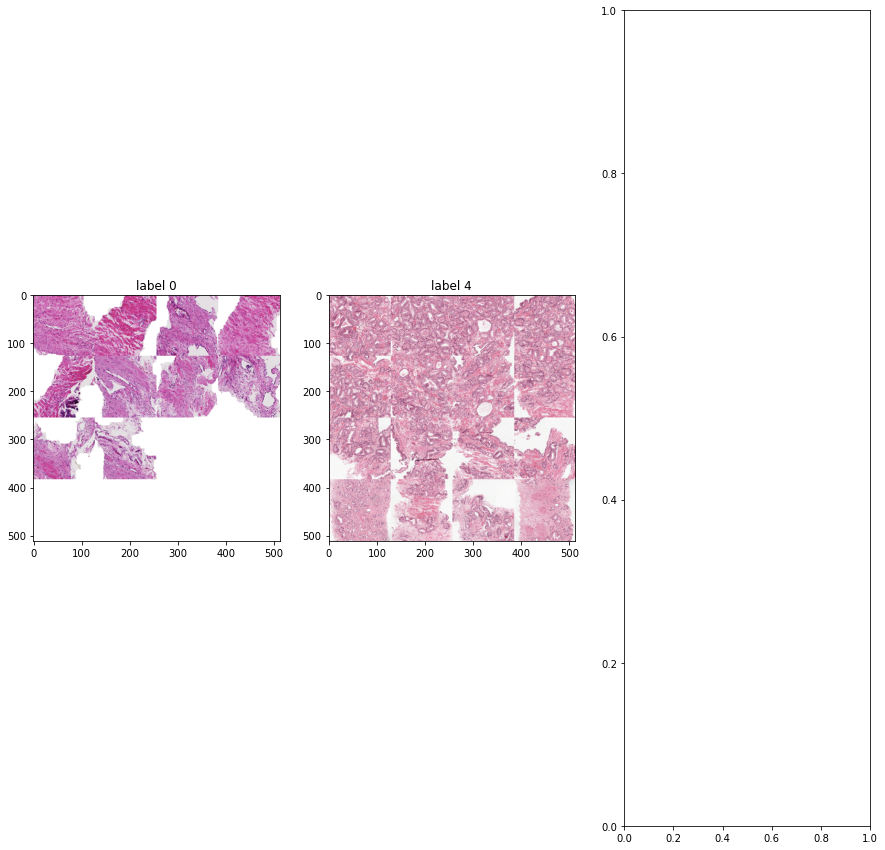

In [3]:
import matplotlib.pyplot as plt
import numpy as np

Xt, yt = train_datagen.__getitem__(0)

print('Shape of X: ', Xt.shape)
print('Shape of y: ', yt.shape)

fig, ax = plt.subplots(figsize=(15, 15), ncols=3)

for i in range(2):
    ax[i].imshow(Xt[i])
    ax[i].set_title('label {}'.format(np.argmax(yt[i, ])))
plt.show()



In [4]:
import models

model = models.build_seresnext()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

cb1 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=1, min_lr=1e-6)
cb2 = ModelCheckpoint("best_seresnext50.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')



In [6]:


history = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    callbacks=[cb1, cb2],
    epochs=gradcam.config.num_epochs,
    verbose=1
)



Epoch 1/10
242/242 [==============================] - ETA: 0s - loss: 1.8970 - cohen_kappa: 0.1056
Epoch 1: val_loss improved from inf to 186865.82812, saving model to best_seresnext50.h5
242/242 [==============================] - 121s 394ms/step - loss: 1.8970 - cohen_kappa: 0.1056 - val_loss: 186865.8281 - val_cohen_kappa: -1.1921e-07 - lr: 0.0030
Epoch 2/10
242/242 [==============================] - ETA: 0s - loss: 1.8661 - cohen_kappa: 0.0478
Epoch 2: val_loss improved from 186865.82812 to 6.28052, saving model to best_seresnext50.h5
242/242 [==============================] - 92s 381ms/step - loss: 1.8661 - cohen_kappa: 0.0478 - val_loss: 6.2805 - val_cohen_kappa: -0.0414 - lr: 0.0030
Epoch 3/10
242/242 [==============================] - ETA: 0s - loss: 1.8606 - cohen_kappa: 0.0040
Epoch 3: val_loss improved from 6.28052 to 6.13688, saving model to best_seresnext50.h5
242/242 [==============================] - 93s 383ms/step - loss: 1.8606 - cohen_kappa: 0.0040 - val_loss: 6.1369 -

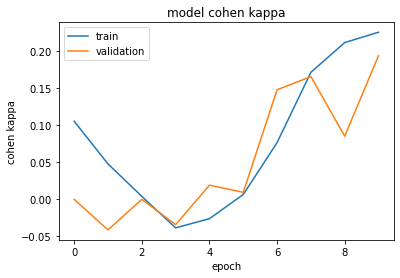

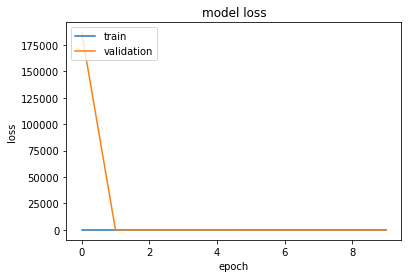

In [7]:
#  "Accuracy"
plt.plot(history.history['cohen_kappa'])
plt.plot(history.history['val_cohen_kappa'])
plt.title('model cohen kappa')
plt.ylabel('cohen kappa')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
model.load_weights('best_seresnext50.h5')

last_conv_layer_name = 'activation_80'
classifier_layer_names = [
    'global_average_pooling2d_16',
    'dense'
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


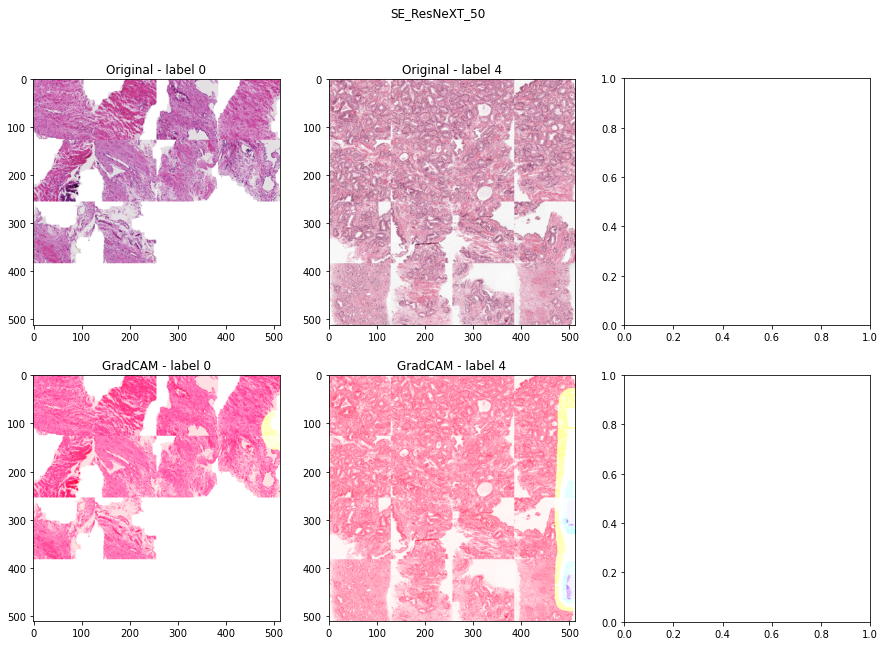

In [9]:
fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)

for i in range(2):
    raw_image = Xt[i]

    image = np.expand_dims(raw_image, axis=0)

    heatmap = gradcam.make_gradcam_heatmap(image, model, last_conv_layer_name, classifier_layer_names)
    superimposed_image = gradcam.create_superimposed_visualization(raw_image, heatmap)

    ax[0][i].imshow(raw_image)
    ax[0][i].set_title('Original - label {}'.format(np.argmax(yt[i, ])))
    ax[1][i].imshow(superimposed_image)
    ax[1][i].set_title('GradCAM - label {}'.format(np.argmax(yt[i, ])))

fig.suptitle('SE_ResNeXT_50')
plt.show()